## $$ H = 4E_C n_q^2 - 2E_J \cos(\phi) + \alpha E_J \cos(2\phi - \phi_{ext}) $$
## $$ E_J / E_C = 100 \quad , \quad \phi_{ext} = 0.01\pi $$
%## $$ %\rightarrow \quad H = 0.04 n_q^2 - 2 \cos(\phi) + \alpha \cos(2\phi - 0.001\pi) $$
## With $\alpha \in [0.5;1]$.. The following is in the $n_q$ basis.

## $$ e^{-i\phi} \rightarrow FT \rightarrow \sum_i |n><n+1|$$
## $$ e^{-i2\phi} \rightarrow FT \rightarrow \sum_i |n><n+2|$$

In [2]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

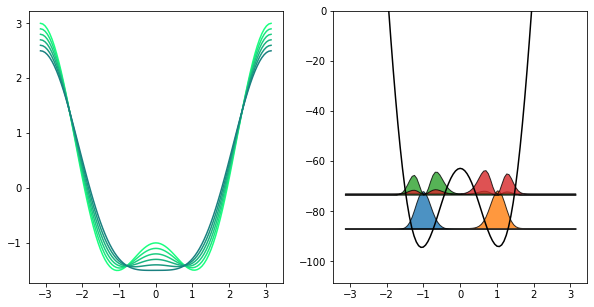

In [310]:
phi_ext = 0.001*t.pi
EJ = 2*t.pi*10 #GHz
EC = EJ/400
def plot_potential(N=101):
    phi = t.linspace(-np.pi,np.pi,N)
    fig, ax = plt.subplots(figsize=(10,5),ncols=2)
    for alpha in np.arange(1,0.4,-0.1):
        ax[0].plot(phi, -2*t.cos(phi) + alpha*t.cos(2*phi - phi_ext),c=(0.1,alpha,0.5))
    
    double_diff = (t.diag(-2*t.ones(N)) + t.diag(t.ones(N-1),1) + t.diag(t.ones(N-1),-1)).type(t.complex128)
    dphi = (phi[1:] - phi[:-1]).mean().item()
    KinE = -4*EC/dphi**2*double_diff
    V_E = -2*EJ*t.diag(t.cos(phi)) + EJ*t.diag(t.cos(2*phi - phi_ext))

    eigvals, eigvecs = t.linalg.eigh(KinE + V_E)
    eigvecs = eigvecs.T

    ax[1].plot(phi,-2*EJ*t.cos(phi) + EJ*t.cos(2*phi - phi_ext),'k')
    indices = [0,1,2,3]
    for i in indices:
        ax[1].fill_between(phi,t.abs(eigvecs[i])**2*2*EJ+eigvals[i],eigvals[i],label='n=%d'%i,edgecolor='k',alpha=0.8)
    ax[1].set_ylim(None,0)
    return #eigvals[:21]

plot_potential(N=101)

- I have checked that is is in agreeance with the flux basis, and that you need higher resolution for the flux basis to achieve the same precision that the charge basis gets with lower resolution.

- I have also checked that to change between the two simply seems to be a dfft, ie. ( ft = t.fft.ifft(eigvecs\[0\])*np.sqrt(N) to go from charge to flux ) except that the ordering of 'ft' is now \[0,..,+max_freq,-max_freq,...,-0.001\] (see torch.fft.fftshift docs)

In [311]:
N = 21
q = t.linspace(-(N - 1)//2,N//2,N)

q_mat = t.diag(q)
def V_mat(alpha=1):
    return -EJ*(t.diag(t.ones(N-1,dtype=t.complex128),-1) + t.diag(t.ones(N-1),1)) + EJ*alpha/2*(t.diag(t.ones(N-2),-2)*t.exp(t.tensor(-1j*phi_ext)) + t.diag(t.ones(N-2),2)*t.exp(t.tensor(1j*phi_ext)))

H = 4*EC*q_mat**2 + V_mat()

eigvals, eigvecs = t.linalg.eigh(H)
eigvecs = eigvecs.T

In [423]:
class System(t.nn.Module):
    def __init__(self, T, NTrot, NHilbert):
        super(System,self).__init__()
        self.T = T
        self.NTrot = NTrot
        self.NHilbert = NHilbert

        self.times = t.linspace(0,T,self.NTrot)
        self.dt = (self.times[1:] - self.times[:-1]).mean().item()
        self.Id = t.eye(self.NHilbert, dtype=t.complex128)
    
    def plot_restrict_time(self):
        assert self.restrict_time
        tmp = t.linspace(-20,self.T+20,100)
        fig, ax = plt.subplots(figsize=(15,5),ncols=3)
        ax[0].plot(tmp,self.restrict_time(tmp))
        ax[0].hlines([0,self.T],tmp.min(),tmp.max(),color='k',linestyle='--')
        zoom = 5
        mask = (tmp>self.T-zoom)&(tmp<self.T+zoom)
        ax[1].plot(tmp[mask],self.restrict_time(tmp)[mask])
        ax[1].hlines(self.T,self.T-zoom,self.T+zoom,'k',linestyle='--')
        ax[1].vlines(self.T,self.T-0.5,self.T+0.5,'b',linestyle='--')
        mask = (tmp>0-zoom)&(tmp<0+zoom)
        ax[2].plot(tmp[mask],self.restrict_time(tmp)[mask])
        ax[2].hlines(0,0-zoom,0+zoom,'k',linestyle='--')
        ax[2].vlines(0,0-0.5,0+0.5,'b',linestyle='--')
        return
    
    def plot_activation_func(self):
        assert self.activation_func
        plt.plot(self.times,self.activation_func(self.times).detach(),'b.')
        plt.ylim(0,None)
        try:
            plt.plot(self.times, self.control.detach()+0.5)
        except:
            pass
        return
    
    

class Flensmon(System):
    def __init__(self, T, NTrot, NHilbert=N, EC=EC, phi_ext=phi_ext, eigvecs=eigvecs):
        super(Flensmon,self).__init__(T, NTrot, NHilbert)
        self.EC = EC
        self.phi_ext = phi_ext

        self.prepare_KinE()
        self.prepare_V()
        self.prepare_eig_H()
        self.ReLU = t.nn.ReLU()
        self.Softplus = t.nn.Softplus()

        self.decline_end = t.nn.parameter.Parameter(t.tensor(1.*self.T))
        self.ascend_start = t.nn.parameter.Parameter(t.tensor(0.*self.T))
        self.control = t.nn.parameter.Parameter(self.init_control())

        self.prepare_target_gate_adj()
    
    def forward(self):
        H = self.get_H(self.activation_func(self.times).flip(0))
        return t.linalg.multi_dot(list(mat for mat in t.matrix_exp(-1j*H*self.dt)))

    def prepare_KinE(self):
        q = t.linspace(-(self.NHilbert - 1)//2,self.NHilbert//2,self.NHilbert)
        self.q_mat = t.diag(q)
        self.KinE = 4*self.EC*self.q_mat**2
    
    def prepare_V(self):
        N = self.NHilbert
        self.cos_mat = (t.diag(t.ones(N-1),-1) + t.diag(t.ones(N-1),1)).type(t.complex128)
        self.cos2_mat = (t.diag(t.ones(N-2,dtype=t.complex128),-2)*t.exp(t.tensor(-1j*phi_ext)) + t.diag(t.ones(N-2),2)*t.exp(t.tensor(1j*phi_ext)))
    
    def get_H(self,alpha=1):
        if type(alpha) == t.Tensor:
            H = self.KinE.repeat((self.NTrot,1,1)) \
                -EJ*self.cos_mat.repeat((self.NTrot,1,1)) \
                + EJ*alpha.view(-1,1,1)/2*self.cos2_mat \
                + EJ*self.control.flip(0).view(-1,1,1)*self.q_mat
            return H
        else:
            return self.KinE - EJ*self.cos_mat + EJ*alpha/2*self.cos2_mat
    
    def prepare_eig_H(self):
        H = self.get_H()
        eigvals, eigvecs = t.linalg.eigh(H)
        self.eigvals = eigvals
        self.eigvecs = eigvecs.T

    def prepare_target_gate_adj(self):
        #X-gate
        tmp = t.diag(t.ones(self.NHilbert,dtype=t.complex128))
        tmp[0,0] = 0
        tmp[0,1] = 1
        tmp[1,0] = 1
        tmp[1,1] = 0
        self.target_gate_adj = tmp

        #For loss_func:
        ones = t.ones(self.NTrot-1)
        self.diff = 1/(2*self.dt)*(t.diag(ones,1)+t.diag(-ones,-1))
        self.ddiff = 1/(self.dt**2)*(t.diag(-2*t.ones(self.NTrot)) + t.diag(ones,1) + t.diag(ones,-1))
    
    def init_control(self):
        width = 40
        A = np.sqrt(t.pi/width)
        envelope = A*t.exp(-(self.times-self.T/2)**2/width)
        omega_d = self.eigvals[1] - self.eigvals[0]
        pulse = t.cos(10*omega_d*self.times)
        return envelope*pulse

    def activation_func(self,time):
        decline_end = self.restrict_time(self.decline_end)
        ascend_start = self.restrict_time(self.ascend_start)

        left_slope = self.ReLU(decline_end - time)/decline_end
        right_slope = self.ReLU(time - ascend_start)/(self.T - ascend_start)
        return (left_slope + right_slope)/2 + 0.5
    
    def restrict_time(self, time_point):
        return self.Softplus(time_point) - self.Softplus(time_point - self.T)
    
    def loss_func(self,U):
        gate = self.eigvecs@U@self.eigvecs.adjoint()
        C1 = 1 - 1/self.NHilbert**2*t.square(t.abs(t.trace(t.mm(self.target_gate_adj,gate))))

        # C1 = 1 - t.square(t.abs(self.eigvecs[1]@U@eigvecs[0]))
        C3 = t.sum(t.square(self.diff@self.control))
        C5 = t.sum(t.square(self.ddiff@self.control))
        return C1 + C3/100 + C5/10000


In [424]:
model = Flensmon(30, 500, N)
optimizer = t.optim.Adam(model.parameters(),lr=1e-2)

In [414]:
def epoch(threshold, N_max):
    from time import time
    optimizer.zero_grad()
    loss = model.loss_func(model())
    loss.backward()
    optimizer.step()

    print(f"initial loss: {loss.item()}")

    N = 1

    start_time = time()
    while loss >= threshold and N <= N_max:
        optimizer.zero_grad()
        loss = model.loss_func(model())
        loss.backward()
        optimizer.step()
        N += 1
        print(f"loss: {loss.item()}, step: {N}", end='\r')
    print(f"Ended at step: {N}, with loss: {loss.item()} and runtime: {time() - start_time}")

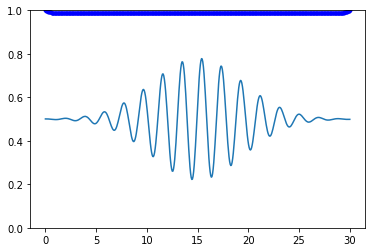

In [425]:
model.plot_activation_func()

In [426]:
model.loss_func(model())

tensor(1.5992, dtype=torch.float64, grad_fn=<AddBackward0>)

In [430]:
epoch(0.1,1000)

initial loss: 1.1657858293768275
Ended at step: 1001, with loss: 1.1127651939883563 and runtime: 404.4015917778015


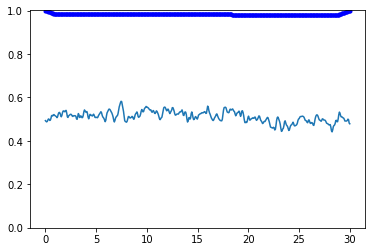

In [431]:
model.plot_activation_func()